# Resolution index analysis by Lindsay

# Defining the dataframe

In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
import math
import seaborn as sns
%matplotlib inline
sns.set(style='whitegrid', color_codes = True)

In [2]:
ps = pd.read_csv('patch_seq_log_mouse.csv')

In [3]:
ps = ps[["Date", "User","Ephys", "Morph", "Post patch?", "Post patch pipette R", "Nucleus sucked in?", "Notes", "Internal version", "PCR cycles", "SM_QC_PF", "Resolution index", "Res index pctl.", "Bad dates"]]
#ps.dropna(subset = ["SM_QC_PF", "Post patch?"], inplace = True)
ps.dropna(subset = ["Post patch?"], inplace = True)
ps["User"] = ps["User"].astype("category")
ps["Post patch?"] = ps["Post patch?"].astype("category")
ps["SM_QC_PF"] = ps["SM_QC_PF"].astype("category")
ps = ps[ps["Bad dates"] != 'x']
ps = ps[ps["SM_QC_PF"] != "cnt"]
ps = ps[ps["PCR cycles"] == 21]
ps = ps.drop('Bad dates', 1)
ps["Date"] = pd.to_datetime(ps["Date"], format = '%y%m%d')
ps.dropna(subset = ["Resolution index"], inplace=True)
#ps["PCR cycles"].value_counts()
ps

,Date,User,Ephys,Morph,Post patch?,Post patch pipette R,Nucleus sucked in?,Notes,Internal version,PCR cycles,SM_QC_PF,Resolution index,Res index pctl.
4969,2017-04-19,P2,x,y,Outside-Out,NaN,NaN,NaN,AiV2,21.0,pass,0.923406,66.0
4971,2017-04-19,P2,x,y,Nucleated,NaN,NaN,NaN,AiV2,21.0,pass,0.000000,10.0
4972,2017-04-19,P2,x,y,Outside-Out,NaN,NaN,NaN,AiV2,21.0,pass,0.322631,23.0
4973,2017-04-19,P2,x,y,Nucleated,NaN,NaN,NaN,AiV2,21.0,pass,0.322631,23.0
4974,2017-04-19,P2,x,n,No-Seal,NaN,NaN,NaN,AiV2,21.0,pass,0.000000,10.0
4979,2017-04-19,P6,x,n,No-Seal,NaN,NaN,NaN,AiV2,21.0,pass,0.000000,10.0
4988,2017-04-20,P1,x,NaN,Nucleated,NaN,NaN,NaN,AiV2,21.0,pass,0.601033,43.0
4989,2017-04-20,P1,x,NaN,No-Seal,NaN,NaN,NaN,AiV2,21.0,pass,0.000000,10.0
4990,2017-04-20,P1,x,NaN,No-Seal,NaN,NaN,NaN,AiV2,21.0,pass,0.000000,10.0
4991,2017-04-20,P1,x,NaN,No-Seal,NaN,NaN,NaN,AiV2,21.0,pass,0.000000,10.0


# Defining Functions

#### defining counting functions

In [4]:
def get_count(x):    
    count = x["Post patch?"].count()
    return count

def calc_pct(part,total):
    pct = float(get_count(part)) / get_count(total)
    return pct

#### defining filtering functions

In [5]:
#input is a dataframe

def nucleated(x):
    nucleus = x[(x["Post patch?"] == "Nucleated") | (((x["Post patch?"] == "nucleus_visible") | (x["Post patch?"] == "nucleus_present")) & (x["Post patch pipette R"] >= 501))]
    return nucleus

def partial_nucleated(y):
    partial = y[(y["Post patch?"] == 'Partial-Nucleus') | (((y['Post patch?'] == 'nucleus_present') | (y['Post patch?'] == 'nucleus_visible')) & (y["Post patch pipette R"] <= 500))]
    return partial

def outside_out(z):
    outside = z[(z["Post patch?"] == 'Outside-Out') | (((z['Post patch?'] == 'nucleus_absent') | (z['Post patch?'] == 'no_nuclues_visible')) & (z['Post patch pipette R'] >= 501))]
    return outside

def no_seal(w): 
    no = w[(w["Post patch?"] == 'No-Seal') | (((w['Post patch?'] == 'nucleus_absent') | (w['Post patch?'] == 'no_nucleus_visible')) & (w['Post patch pipette R'] <= 500))]
    return no
    
def pass_only(df):
    pas = df[df["SM_QC_PF"] == "pass"]
    return pas

def gen_filter(df, col, cond):
    filtr = df[df[col] == cond]
    return filtr

def hi_res(df):
    hi = df[df["Resolution index"] >= 0.8]
    return hi


# Creating a dataframe by post patch class

In [6]:
nuc = nucleated(ps)
nuc["post patch class"] = "Nucleated"

part_nuc = partial_nucleated(ps)
part_nuc["post patch class"] = "Partial nucleated"

out_out = outside_out(ps)
out_out["post patch class"] = "Outside out"

noSeal = no_seal(ps)
noSeal["post patch class"] = "No seal"

entirecell = ps[ps["Post patch?"] == "Entire-Cell"]
entirecell["post patch class"] = "Entire cell"

frames = [nuc, part_nuc, out_out, noSeal, entirecell]
ps2 = pd.concat(frames)
ps2

C:\Users\lindsayn\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\lindsayn\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\lindsayn\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

,Date,User,Ephys,Morph,Post patch?,Post patch pipette R,Nucleus sucked in?,Notes,Internal version,PCR cycles,SM_QC_PF,Resolution index,Res index pctl.,post patch class
4971,2017-04-19,P2,x,y,Nucleated,NaN,NaN,NaN,AiV2,21.0,pass,0.000000,10.0,Nucleated
4973,2017-04-19,P2,x,y,Nucleated,NaN,NaN,NaN,AiV2,21.0,pass,0.322631,23.0,Nucleated
4988,2017-04-20,P1,x,NaN,Nucleated,NaN,NaN,NaN,AiV2,21.0,pass,0.601033,43.0,Nucleated
5009,2017-04-20,P2,x,NaN,Nucleated,NaN,NaN,NaN,AiV2,21.0,pass,0.678447,50.0,Nucleated
5022,2017-04-21,P1,?,n,Nucleated,NaN,NaN,"Fluorescence in Pipette,Cell Dimmed",AiV2,21.0,pass,0.795757,56.0,Nucleated
5026,2017-04-21,P2,x,n,Nucleated,NaN,NaN,Fluorescence in Pipette,AiV2,21.0,pass,1.000000,100.0,Nucleated
5027,2017-04-21,P2,x,y,Nucleated,NaN,NaN,Fluorescence in Pipette,AiV2,21.0,pass,0.877682,64.0,Nucleated
5035,2017-04-21,P2,x,n,Nucleated,NaN,NaN,NaN,AiV2,21.0,pass,0.556320,38.0,Nucleated
5045,2017-04-24,P1,x,NaN,Nucleated,NaN,NaN,Fluorescence in Pipette,AiV2,21.0,pass,0.601033,43.0,Nucleated
5051,2017-04-24,P1,x,y,Nucleated,NaN,NaN,Fluorescence in Pipette a few small bubbles,AiV2,21.0,pass,1.000000,100.0,Nucleated


# Resolution Index vs post patch condition for pre and post alexa experiments

#### comparing standard to alexa internal

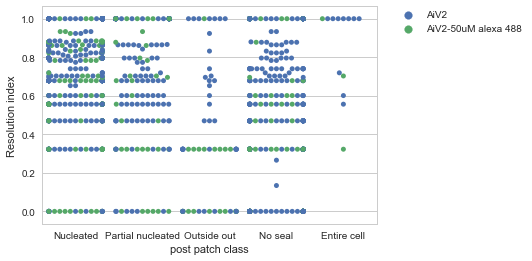

In [7]:
sns.swarmplot(x = "post patch class", y ="Resolution index", hue = "Internal version", data=ps2)
plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.)

In [8]:
pre_alexa = gen_filter(ps2, "Internal version", "AiV2")
post_alexa = gen_filter(ps2, "Internal version", "AiV2-50uM alexa 488" )

#### alexa internal only

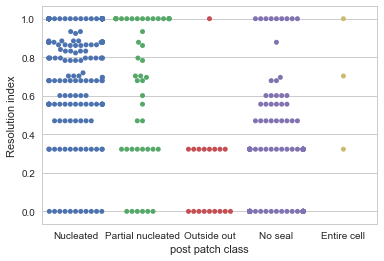

In [9]:
sns.swarmplot(x = "post patch class", y = "Resolution index", data=post_alexa)

#### standard internal only

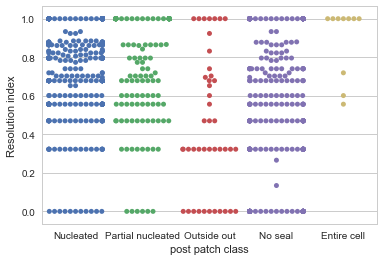

In [10]:
sns.swarmplot(x = "post patch class", y = "Resolution index", data = pre_alexa)

# Calculating occurance of resolution index > 0.8 (high resolution)

### First attempts:

In [11]:
for frame in frames:
    hi_res_occurance = calc_pct(hi_res(frame), frame)
    print "high resolution occurance:" , hi_res_occurance

high resolution occurance: 0.594451783355
high resolution occurance: 0.494565217391
high resolution occurance: 0.16393442623
high resolution occurance: 0.258660508083
high resolution occurance: 0.6


In [12]:
def hi_res_occur(frame, postpatch):
    hi_res_occurance = calc_pct(hi_res(frame), frame)
    print postpatch,":", hi_res_occurance
    
hi_res_occur(nuc, "Nucleated")
hi_res_occur(part_nuc, "Partial Nucleated")
hi_res_occur(out_out, "Outside out")
hi_res_occur(noSeal, "No Seal")
hi_res_occur(entirecell, "Entire cell")

Nucleated : 0.594451783355
Partial Nucleated : 0.494565217391
Outside out : 0.16393442623
No Seal : 0.258660508083
Entire cell : 0.6


### Use this one:

In [13]:
# calculates the occurance of high resolution index for each post patch condition

def hi_res_occ(frame, postpatch):
    total = gen_filter(frame, "post patch class", postpatch)
    hi_reso = hi_res(total)
    hi_res_oc = calc_pct(hi_reso, total)
    print postpatch, ":" , hi_res_oc

hi_res_occ(ps2, "Nucleated")
hi_res_occ(ps2, "Partial nucleated")
hi_res_occ(ps2,"Outside out")
hi_res_occ(ps2,"No seal")
hi_res_occ(ps2,"Entire cell")
    

Nucleated : 0.594451783355
Partial nucleated : 0.494565217391
Outside out : 0.16393442623
No seal : 0.258660508083
Entire cell : 0.6


# Calculating occurance of resolution index > 0.8 (high resolution) by internal version

#### Occurance of high resolution index in pre alexa expreiments

In [14]:
hi_res_occ(pre_alexa, "Nucleated")
hi_res_occ(pre_alexa, "Partial nucleated")
hi_res_occ(pre_alexa,"Outside out")
hi_res_occ(pre_alexa,"No seal")
hi_res_occ(pre_alexa,"Entire cell")

Nucleated : 0.601869158879
Partial nucleated : 0.510948905109
Outside out : 0.209302325581
No seal : 0.325878594249
Entire cell : 0.7


#### Occurance of high resolution index in post alexa expreiments

In [15]:
hi_res_occ(post_alexa, "Nucleated")
hi_res_occ(post_alexa, "Partial nucleated")
hi_res_occ(post_alexa,"Outside out")
hi_res_occ(post_alexa,"No seal")
hi_res_occ(post_alexa,"Entire cell")

Nucleated : 0.579185520362
Partial nucleated : 0.431818181818
Outside out : 0.0555555555556
No seal : 0.0833333333333
Entire cell : 0.333333333333


# Resolution Index Percentile vs post patch condition for pre and post alexa experiments

#### comparing standard to alexa internal

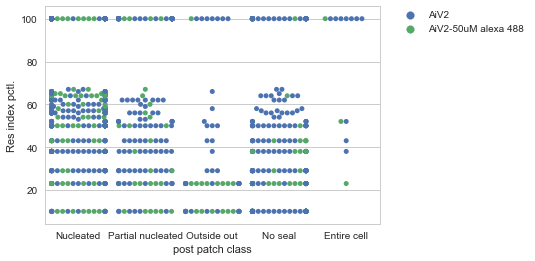

In [16]:
sns.swarmplot(x = "post patch class", y ="Res index pctl.", hue = "Internal version", data=ps2)
plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.)

# Calculating occurance of Triple Modality experiments (Ephys pass, Morpho pass, High RI)

In [17]:
Ephys_pass = gen_filter(ps2, "Ephys", "x")
#Ephys_pass

In [18]:
Ephys_and_morpho_pass = gen_filter(Ephys_pass, "Morph", "y")
#Ephys_and_morpho_pass

In [19]:
Triple_mod = hi_res(Ephys_and_morpho_pass)
Triple_mod

,Date,User,Ephys,Morph,Post patch?,Post patch pipette R,Nucleus sucked in?,Notes,Internal version,PCR cycles,SM_QC_PF,Resolution index,Res index pctl.,post patch class
5027,2017-04-21,P2,x,y,Nucleated,NaN,NaN,Fluorescence in Pipette,AiV2,21.0,pass,0.877682,64.0,Nucleated
5051,2017-04-24,P1,x,y,Nucleated,NaN,NaN,Fluorescence in Pipette a few small bubbles,AiV2,21.0,pass,1.000000,100.0,Nucleated
5215,2017-05-02,P1,x,y,Nucleated,NaN,NaN,"Cell Dimmed,Cell Shrunk a couple small bubbles",AiV2,21.0,pass,1.000000,100.0,Nucleated
5225,2017-05-02,P2,x,y,Nucleated,NaN,NaN,Fluorescence in Pipette sucked up nucleus duri...,AiV2,21.0,pass,1.000000,100.0,Nucleated
5226,2017-05-02,P2,x,y,Nucleated,NaN,NaN,Fluorescence in Pipette sucked nucleus up into...,AiV2,21.0,pass,1.000000,100.0,Nucleated
5234,2017-05-02,P2,x,y,Nucleated,NaN,NaN,Fluorescence in Pipette very few small bubbles...,AiV2,21.0,pass,1.000000,100.0,Nucleated
5250,2017-05-03,P1,x,y,Nucleated,NaN,NaN,"Fluorescence in Pipette,Cell Dimmed lots of ...",AiV2,21.0,pass,1.000000,100.0,Nucleated
5251,2017-05-03,P1,x,y,Nucleated,NaN,NaN,"Fluorescence in Pipette,Cell Dimmed lots of ...",AiV2,21.0,pass,1.000000,100.0,Nucleated
5261,2017-05-03,P2,x,y,Nucleated,NaN,NaN,few small bubbles formed during expulsion.,AiV2,21.0,pass,1.000000,100.0,Nucleated
5262,2017-05-03,P2,x,y,Nucleated,NaN,NaN,lots of little bubbles formed during expulsion...,AiV2,21.0,pass,1.000000,100.0,Nucleated


In [20]:
calc_pct(Triple_mod, ps2)

0.12137931034482759

# Plots

In [21]:
hi_res_data = hi_res(ps2)
hi_res_data

,Date,User,Ephys,Morph,Post patch?,Post patch pipette R,Nucleus sucked in?,Notes,Internal version,PCR cycles,SM_QC_PF,Resolution index,Res index pctl.,post patch class
5026,2017-04-21,P2,x,n,Nucleated,NaN,NaN,Fluorescence in Pipette,AiV2,21.0,pass,1.000000,100.0,Nucleated
5027,2017-04-21,P2,x,y,Nucleated,NaN,NaN,Fluorescence in Pipette,AiV2,21.0,pass,0.877682,64.0,Nucleated
5051,2017-04-24,P1,x,y,Nucleated,NaN,NaN,Fluorescence in Pipette a few small bubbles,AiV2,21.0,pass,1.000000,100.0,Nucleated
5084,2017-04-25,P2,x,n,Nucleated,NaN,NaN,NaN,AiV2,21.0,pass,1.000000,100.0,Nucleated
5085,2017-04-25,P2,x,n,Nucleated,NaN,NaN,Fluorescence in Pipette,AiV2,21.0,pass,1.000000,100.0,Nucleated
5089,2017-04-25,P2,x,q,Nucleated,NaN,NaN,no bubbles during expulsion.,AiV2,21.0,pass,1.000000,100.0,Nucleated
5117,2017-04-26,P2,x,q,Nucleated,NaN,NaN,Fluorescence in Pipette large bubble formed du...,AiV2,21.0,pass,1.000000,100.0,Nucleated
5164,2017-04-28,P2,x,q,Nucleated,NaN,NaN,one small bubble formed during expulsion.,AiV2,21.0,pass,1.000000,100.0,Nucleated
5192,2017-05-01,P2,x,q,Nucleated,NaN,NaN,Fluorescence in Pipette one big bubble formed ...,AiV2,21.0,pass,1.000000,100.0,Nucleated
5199,2017-05-01,P6,x,q,Nucleated,NaN,NaN,NaN,AiV2,21.0,pass,0.805486,57.0,Nucleated


#### Resolution index vs post patch outcome

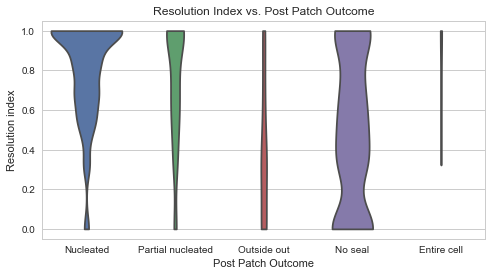

In [22]:
fig, ax = plt.subplots()
fig.set_size_inches(7, 4)
sns.violinplot(x="post patch class", y="Resolution index", data=ps2, inner=None, cut =0, scale='count',ax=ax)
#sns.swarmplot(x="post patch class", y="Resolution index", data=ps2, color="w", alpha=.5);
#sns.swarmplot(x="post patch class", y="Resolution index", data=hi_res_data, color="w", alpha=.5);
#sns.set_context("poster")
plt.title("Resolution Index vs. Post Patch Outcome")
plt.xlabel("Post Patch Outcome")
#plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("RI plot",dpi=200)


#### Resolution index vs post patch outcome: scale = area

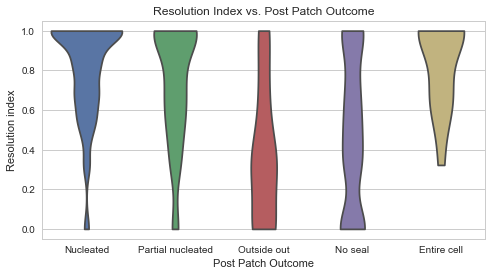

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches(7, 4)
sns.violinplot(x="post patch class", y="Resolution index", data=ps2, inner=None, cut =0, scale='area', ax=ax)
plt.title("Resolution Index vs. Post Patch Outcome")
plt.xlabel("Post Patch Outcome")
#plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("RI plot-area",dpi=200)


In [24]:
ps["Date"].head()

4969   2017-04-19
4971   2017-04-19
4972   2017-04-19
4973   2017-04-19
4974   2017-04-19
Name: Date, dtype: datetime64[ns]

In [25]:
ps["Date"].tail()

7534   2017-10-11
7535   2017-10-11
7536   2017-10-11
7537   2017-10-11
7538   2017-10-11
Name: Date, dtype: datetime64[ns]

#### Plot for Brian - Nucleated patch Reolution Index only

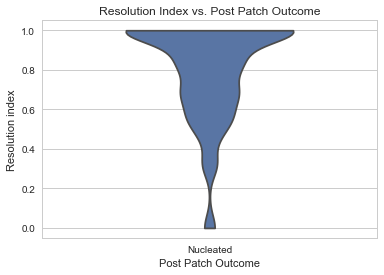

In [26]:
ps3= gen_filter(ps2, "post patch class", "Nucleated")
sns.violinplot(x="post patch class", y="Resolution index", data=ps3, inner=None, cut =0, scale='area', width=0.5)
plt.title("Resolution Index vs. Post Patch Outcome")
plt.xlabel("Post Patch Outcome")
#plt.xticks(rotation=30)
#plt.tight_layout()
plt.savefig("RI plot-nucleated",dpi=200)


#### Resolution index percentile vs post patch outcome

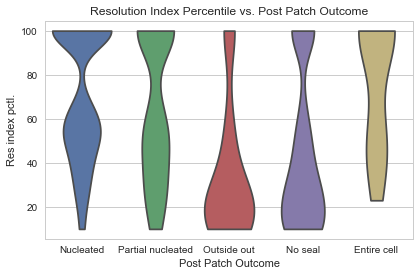

In [27]:
sns.violinplot(x="post patch class", y="Res index pctl.", data=ps2, inner=None, cut =0, scale='area')
plt.title("Resolution Index Percentile vs. Post Patch Outcome")
plt.xlabel("Post Patch Outcome")
#plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("RI percentile plot-area",dpi=200)


#### Resolution index vs post patch outcome: scale = area PRE ALEXA

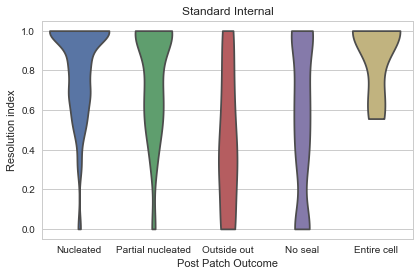

In [28]:
sns.violinplot(x="post patch class", y="Resolution index", data=pre_alexa, inner=None, cut =0, scale='area')
plt.title("Standard Internal")
plt.xlabel("Post Patch Outcome")
#plt.figure(figsize=(8, 6))
#plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("RI plot-pre_alexa",dpi=200)

#### Resolution index vs post patch outcome: scale = area POST ALEXA

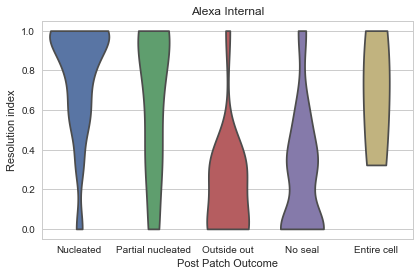

In [29]:
sns.violinplot(x="post patch class", y="Resolution index", data=post_alexa, inner=None, cut =0, scale='area')
plt.title("Alexa Internal")
plt.xlabel("Post Patch Outcome")
#plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("RI plot-post_alexa",dpi=200)

#### Comparing RI standard internal vs alexa

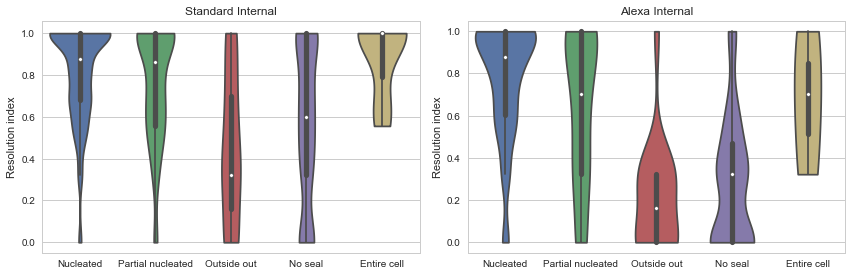

In [30]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
#f, (ax1, ax2) = plt.subplots(2, figsize=(7,7))
sns.violinplot(x="post patch class", y="Resolution index", data=pre_alexa, inner="box", cut =0, scale='area', ax=ax1)
ax1.set_title("Standard Internal")
ax1.set_xlabel('')
sns.violinplot(x="post patch class", y="Resolution index", data=post_alexa, inner="box", cut =0, scale='area', ax=ax2)
ax2.set_title("Alexa Internal")
ax2.set_xlabel('')
plt.tight_layout()
plt.savefig("RI plot-alexa vs standard", dpi=100)

In [31]:
ps["Resolution index"].mean()

0.6815844330006926

In [32]:
get_count(post_alexa)

406

In [33]:
get_count(pre_alexa)

1038